### ***Imports & Load Data***

In [6]:
import pandas as pd
import numpy as np
import re

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)
from sklearn.utils import resample

import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

In [7]:
# Load processed dataset from Preprocessing step
# If you used a different name, change the path here
df = pd.read_csv("../Data/Processed/flipkart_model_ready.csv")

print("Shape:", df.shape)
df.head()

Shape: (1429, 13)


,rating,review_title,review_text,reviewer_name,verified_purchase,review_date,helpful_upvotes,helpful_total,review_date_raw,product,sentiment,clean_text,word_count
0,4.0,Pretty good,Good compact phone and having good camera but ...,Swayam Vish,True,2024-11-01,37.0,4.0,1 month ago,Samsung S24,positive,good compact phone good camera facing issu bat...,21
1,4.0,Good quality product,After using S24 for 4 days am writing this rev...,Jayasuriya Anbu,True,2024-11-01,127.0,27.0,1 month ago,Samsung S24,positive,using day writing review overall good compact ...,32
2,5.0,Awesome,Today received this phone. It's just outstandi...,Arnab Deb,True,2024-11-01,10.0,0.0,1 month ago,Samsung S24,positive,today received phone outstanding battery good ...,19
3,5.0,Mind-blowing purchase,"Powerful performance, excellent display,compac...",Amit Kumar Behera,True,2024-11-01,34.0,6.0,1 month ago,Samsung S24,positive,powerful performance excellent display compact...,14
4,5.0,Brilliant,Just looking like a wow,Raja,True,2024-11-01,64.0,15.0,1 month ago,Samsung S24,positive,looking like wow,3


### ***Create / Verify Sentiment from Rating***

In [8]:
# Ensure rating is numeric
df["rating"] = pd.to_numeric(df["rating"], errors="coerce")

# If sentiment column doesn't exist or you want to regenerate it:
def label_sentiment(r):
    if pd.isna(r):
        return "neutral"
    r = float(r)
    if r >= 4:
        return "positive"
    elif r <= 2:
        return "negative"
    else:
        return "neutral"

df["sentiment"] = df["rating"].apply(label_sentiment)

print("Sentiment counts (including neutral):")
print(df["sentiment"].value_counts())


Sentiment counts (including neutral):
sentiment
positive    1079
negative     257
neutral       93
Name: count, dtype: int64


### ***Drop Neutral & Clean***

In [9]:
# Drop neutral sentiment
df = df[df["sentiment"] != "neutral"].copy()

# Drop rows with missing text
df = df.dropna(subset=["review_text"])
df["review_text"] = df["review_text"].astype(str)

print("After dropping neutral & NaN text:")
print(df["sentiment"].value_counts())
print("Shape:", df.shape)

After dropping neutral & NaN text:
sentiment
positive    1079
negative     257
Name: count, dtype: int64
Shape: (1336, 13)


### ***Balance the Dataset (Undersampling Positives)***

In [10]:
df_pos = df[df["sentiment"] == "positive"]
df_neg = df[df["sentiment"] == "negative"]

print("Before balancing:")
print("Positive:", len(df_pos))
print("Negative:", len(df_neg))

# target = minority class count (negatives)
target_count = min(len(df_pos), len(df_neg))

df_pos_down = resample(df_pos,
                       replace=False,           # sample without replacement
                       n_samples=target_count,  # same as negative count
                       random_state=42)

df_neg_down = resample(df_neg,
                       replace=False,
                       n_samples=target_count,
                       random_state=42)

df_balanced = pd.concat([df_pos_down, df_neg_down], ignore_index=True)

print("\nAfter balancing (undersampling both to equal):")
print(df_balanced["sentiment"].value_counts())
print("Balanced shape:", df_balanced.shape)

Before balancing:
Positive: 1079
Negative: 257

After balancing (undersampling both to equal):
sentiment
positive    257
negative    257
Name: count, dtype: int64
Balanced shape: (514, 13)


### ***Text Cleaning Function (for Model Input)***

In [11]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("omw-1.4")

stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def clean_text(text: str) -> str:
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r"http\S+|www.\S+", " ", text)        # remove URLs
    text = re.sub(r"[^a-z0-9\s]", " ", text)           # keep letters/numbers/spaces
    tokens = text.split()
    tokens = [t for t in tokens if t not in stop_words and len(t) > 2]
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return " ".join(tokens)

df_balanced["clean_text"] = df_balanced["review_text"].astype(str).apply(clean_text)
df_balanced["word_count"] = df_balanced["clean_text"].str.split().str.len()

df_balanced[["review_text", "clean_text", "sentiment"]].head()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Aakash\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Aakash\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Aakash\AppData\Roaming\nltk_data...


,review_text,clean_text,sentiment
0,for me its 10 out of 10✨,,positive
1,"Great product,must buy if you are iPhone lovers",great product must buy iphone lover,positive
2,"The iPhone 15 excels in design, performance, a...",iphone excels design performance camera capabi...,positive
3,"This phone are not only for show off, these ar...",phone show real master peice content creator r...,positive
4,The camera of iPhone 15 is very good because I...,camera iphone good using everything working fi...,positive


### ***Train/Test Split***

In [12]:
X = df_balanced["clean_text"]
y = df_balanced["sentiment"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print("Train size:", len(X_train))
print("Test size :", len(X_test))
print("Train class distribution:")
print(y_train.value_counts())

Train size: 411
Test size : 103
Train class distribution:
sentiment
positive    206
negative    205
Name: count, dtype: int64


### ***Build TF-IDF + Logistic Regression Pipeline***

In [16]:
model = Pipeline([
    ("tfidf", TfidfVectorizer(
        max_features=5000,
        ngram_range=(1, 2)  # unigrams + bigrams
    )),
    ("clf", LogisticRegression(
        max_iter=1000,
        class_weight="balanced"
    ))
])

model

,steps,"[('tfidf', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None


### ***Train the Model***

In [17]:
model.fit(X_train, y_train)
print("✅ Model training complete.")

✅ Model training complete.


### ***Evaluation Metrics***

In [14]:
y_pred = model.predict(X_test)

acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, pos_label="positive")
rec  = recall_score(y_test, y_pred, pos_label="positive")
f1   = f1_score(y_test, y_pred, pos_label="positive")

print("🔎 Evaluation Metrics (Positive class):")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1:.4f}")

print("\n📄 Classification Report:")
print(classification_report(y_test, y_pred))


🔎 Evaluation Metrics (Positive class):
Accuracy : 0.8447
Precision: 0.8431
Recall   : 0.8431
F1-score : 0.8431

📄 Classification Report:
              precision    recall  f1-score   support

    negative       0.85      0.85      0.85        52
    positive       0.84      0.84      0.84        51

    accuracy                           0.84       103
   macro avg       0.84      0.84      0.84       103
weighted avg       0.84      0.84      0.84       103



### ***Confusion Matrix (Visualization)***

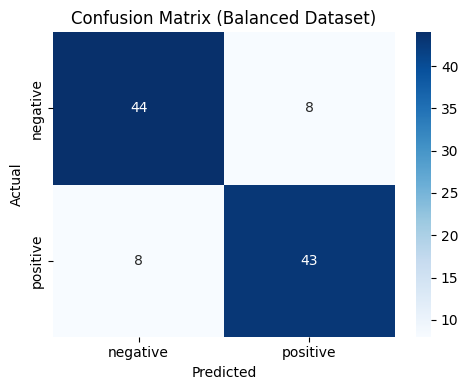

In [15]:
labels = ["negative", "positive"]
cm = confusion_matrix(y_test, y_pred, labels=labels)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Balanced Dataset)")
plt.tight_layout()

os.makedirs("../Data/EDA_Charts", exist_ok=True)
plt.savefig("../Data/EDA_Charts/confusion_matrix_balanced.png", dpi=300)
plt.show()

### ***Save the Trained Model (for FastAPI)***

In [18]:
os.makedirs("../App", exist_ok=True)

model_path = "../App/sentiment_model.pkl"
joblib.dump(model, model_path)

print("✅ Saved trained model pipeline to:", model_path)


✅ Saved trained model pipeline to: ../App/sentiment_model.pkl
